In [1]:
import tensorflow as tf
from keras.datasets import mnist
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras.layers.core import Activation, Flatten, Dense, Dropout
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.layers import Input, Concatenate, Layer
from keras.applications import vgg19
from keras.utils import plot_model
from keras.optimizers import RMSprop
from keras import backend as K
import keras
import h5py
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage

%matplotlib inline

/home/mirlab/miniconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Config Keras

In [4]:
keras.backend.set_image_data_format('channels_last')
keras.backend.image_data_format()

'channels_last'

## Load MNIST dataset

In [5]:
num_classes = 10
_, (X, y) = mnist.load_data()
X = X.astype('float32')
X /= 255
print('X shape:', X.shape)

# convert class vectors to binary class matrices
print('y.shape:', y.shape)

X shape: (10000, 28, 28)
y.shape: (10000,)


## Preprocessing
Obtain a matrix $X_1$, $X_2$, $[w_{ij}]$, and $[s_{ij}]$ where $X_1$ and $X_2$ are pairs of images of shape 
`(n_samples, height, width, 1)`; $[w_{ij}]$ is the weight vector of shape `(n_samples, 1)` which describes the weight of each pair; and $[s_{ij}]$ is a binary vector of shape `(n_samples,1)` indicating whether inputs $i$ and $j$ are the same 

In [7]:
X1 = []
X2 = []
tmpy = []
actual = []
for n in range(1000):
    idx = np.random.randint(X.shape[0], size=2)
    similarity = (y[idx[0]] == y[idx[1]])
    X1.append(X[idx[0]].reshape(28,28,1))
    X2.append(X[idx[1]].reshape(28,28,1))
    actual.append((idx[0], idx[1]))
    tmpy.append(similarity)
X1 = np.array(X1)
X2 = np.array(X2)
y = np.array(tmpy).reshape(-1,1)
actual = np.array(actual)

Calculate the weight vector $[w_{ij}]$. The term $w_{ij}$ is defined as 

$$
    w_{ij} = \begin{cases}
    \frac{|S|}{|S_{1}|} &\text{if $x^{(i)}$ is similar to $x^{(j)}$}\\
    \frac{|S|}{|S_{0}|} &\text{if $x^{(i)}$ is not similar to $x^{(j)}$}
    \end{cases}
$$

In [8]:
n_sim = len(y[y==True])
w_sim   = len(X) / n_sim             # w_ij for similar pairs
w_insim = len(X) / (len(X) - n_sim)  # w_ij for dissimilar pairs
W = y*w_sim + (~y)*w_insim          # w vector for pairs

In [9]:
y = y.astype('float32')

Output some statistics and matrix shape.

In [10]:
print("X1 shape: ", X1.shape)
print("X2 shape: ", X2.shape)
print("y shape: ", y.shape)
print("W shape: ", W.shape)
print("There are {:} out of {:} pairs that are similar".format(n_sim, len(X1)))

X1 shape:  (1000, 28, 28, 1)
X2 shape:  (1000, 28, 28, 1)
y shape:  (1000, 1)
W shape:  (1000, 1)
There are 112 out of 1000 pairs that are similar


# Paired-Annotation Input

In [ ]:
from songdb import *
import librosa
from preprocess import *

In [ ]:
data = data_dict()
ref_query_pairs = data['taylorswift']

In [ ]:
pairedData = np.array([np.zeros((2, 76, 121))])

for ref, query in ref_query_pairs:
    for i in range(ref.shape[0]):
        refQ = preprocess(librosa.cqt(np.asfarray(ref[i], dtype='float32'), sr = 22050, fmin=130.81, n_bins=121, bins_per_octave=24, hop_length=96), 3).T
        queryQ = preprocess(librosa.cqt(np.asfarray(query[i], dtype='float32'), sr = 22050, fmin=130.81, n_bins=121, bins_per_octave=24, hop_length=96), 3).T
        Q = np.append(np.array([refQ]), np.array([queryQ]), axis=0)
        pairedData = np.append(pairedData, np.array([Q]), axis=0)
        
pairedData = pairedData[1:]

# Load PCA Model

In [ ]:
import scipy.io
from model import *

In [ ]:
model_path = '/data1/mint/public/taylorswift_out/model.mat'
model = scipy.io.loadmat(model_path)
evecs = np.array(model['eigvecs']).T

In [ ]:
m = 20
pca_matrix = np.array([vec.reshape((m, -1)) for vec in evecs])
delta = 16

In [ ]:
fp_net = build_model(pca_matrix, refQ.shape, delta=delta, COMPUTE_DELTA=True)

## Model

__Define inputs__

Create a HashNet model with four inputs: two images tensors, similarity vector, and weight vector.

In [11]:
height = 28
width = 28
n_channel = 1

In [12]:
image_a    = Input(shape=(height, width, n_channel), name='image_1')
image_b    = Input(shape=(height, width, n_channel), name='image_2')
similarity = Input(shape=(1,), name="similarity")
weight     = Input(shape=(1,), name="weight")

In [13]:
type(image_a)

tensorflow.python.framework.ops.Tensor

__Pre-trained model__

Use a pre-trained model here to obtain intermediate values from the pre-trained model.

In [42]:
input_image = Input(shape=(height, width, n_channel))
layer1 = Convolution2D(64, (3,3), activation='relu', padding='same', name='block1_conv1')(input_image)
layer2 = Convolution2D(64, (3,3), activation='relu', padding='same', name='block1_conv2')(layer1)
layer3 = MaxPooling2D((2,2), strides=(2,2), name='block1_pool')(layer2)

base_model = Model(input_image, layer3)

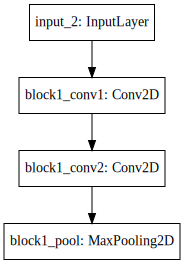

In [43]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(base_model).create(prog='dot', format='svg'))

__Obtain intermediate values__

In [15]:
# Obtain intermediate tensor
intermediate_a = base_model(image_a)
intermediate_b = base_model(image_b)

# Flatten the layer
flatten_a = Flatten()(intermediate_a)
flatten_b = Flatten()(intermediate_b)

__Append a layer for binary encoding__

This layer has a `tanh` activation defined in the same way as HashNet paper.

In [16]:
beta         = 1            # Initial beta value
numberOfBits = 6          
alpha        = 0.5

In [17]:
def custom_activation(x):
    """
    Our own defined activation function
    """
    global beta
    return K.tanh(beta * x)

In [18]:
class CustomizedLossLayer(Layer):
    """
    Our own defined layer for keeping track of loss function
    """
    
    def __init__(self, **kwargs):
        self.is_placeholder = True
        super(CustomizedLossLayer, self).__init__(**kwargs)
    
    def my_loss(self, encoded_a, encoded_b, similarity, weight):
        global alpha
        x = encoded_a
        y = encoded_b
        dot_product = K.sum(x * y, axis=-1, keepdims=True)
        return K.sum(weight * (K.log(1 + K.exp(alpha * dot_product)) - alpha * similarity * dot_product))
    
    def call(self, inputs):
        encoded_a = inputs[0]
        encoded_b = inputs[1]
        similarity = inputs[2]
        weight = inputs[3]
        loss = self.my_loss(encoded_a, encoded_b, similarity, weight)
        self.add_loss(loss, inputs=inputs)
        return K.ones_like(similarity)


In [19]:
dense_layer = Dense(numberOfBits, activation=custom_activation)
encoded_a = dense_layer(flatten_a)
encoded_b = dense_layer(flatten_b)

__Create a model for training__

In [20]:
# Define a loss layer with 4 inputs
loss = CustomizedLossLayer()([encoded_a, encoded_b, similarity, weight])

In [21]:
# Define a model that has 4 inputs and outputs loss
model = Model(inputs=[image_a, image_b, similarity, weight], outputs=[loss])

In [22]:
# Compile the model with our own defined loss function.
# Note that loss function is already defined in a layer, so
# `zero_loss` here doesn't actually do anything.

def zero_loss(y_true, y_pred):
    return K.zeros_like(y_pred)

rmsprop = RMSprop()
model.compile(optimizer=rmsprop, loss=zero_loss)

__Visualize model architecture__

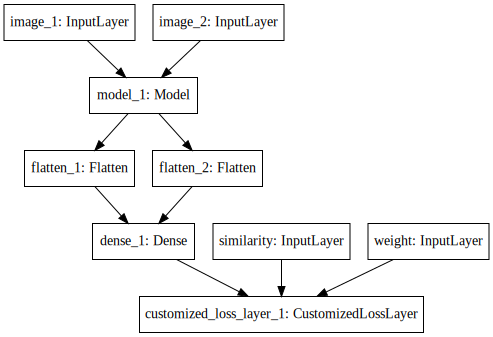

In [23]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model).create(prog='dot', format='svg'))

## Train a model

In [24]:
# Check the input shape
print("X1.shape: ", X1.shape)
print("X2.shape: ", X2.shape)
print("y.shape: ", y.shape)
print("W.shape: ", W.shape)

X1.shape:  (1000, 28, 28, 1)
X2.shape:  (1000, 28, 28, 1)
y.shape:  (1000, 1)
W.shape:  (1000, 1)


In [34]:
number_of_iterations = 30
beta_factor = 50
number_of_epochs = 150

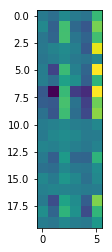

In [41]:
plt.imshow(dense_layer.get_weights()[0][:20])

Iteration 1


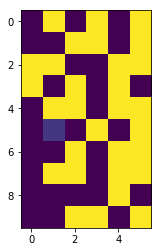

Iteration 2


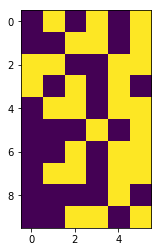

Iteration 3


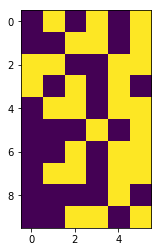

Iteration 4


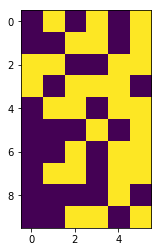

Iteration 5


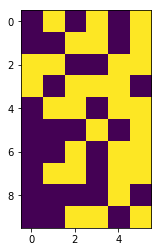

Iteration 6


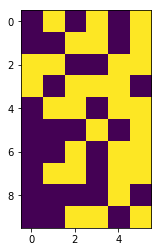

Iteration 7


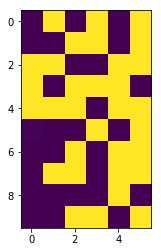

Iteration 8


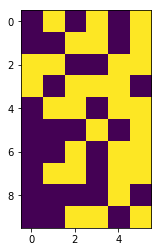

Iteration 9


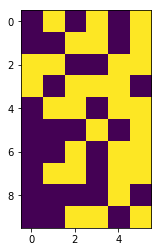

Iteration 10


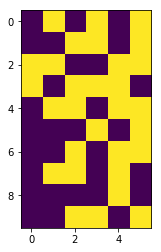

Iteration 11


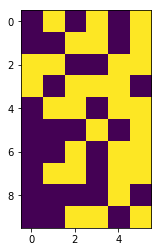

Iteration 12


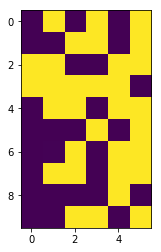

Iteration 13


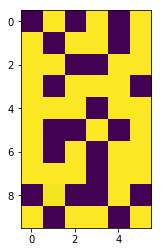

Iteration 14


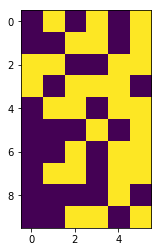

Iteration 15


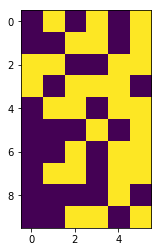

Iteration 16


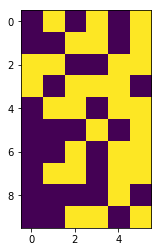

Iteration 17


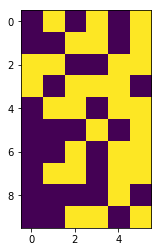

Iteration 18


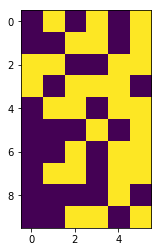

Iteration 19


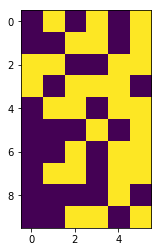

Iteration 20


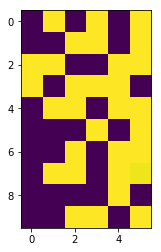

Iteration 21


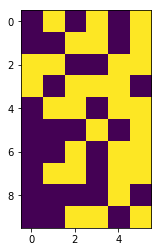

Iteration 22


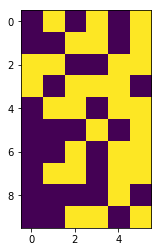

Iteration 23


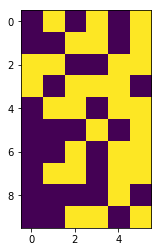

Iteration 24


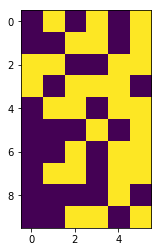

Iteration 25


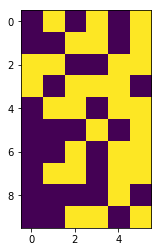

Iteration 26


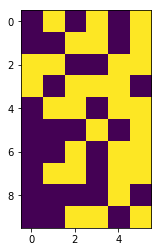

Iteration 27


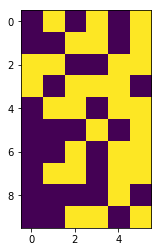

Iteration 28


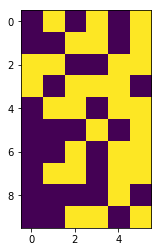

Iteration 29


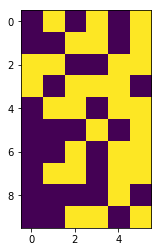

Iteration 30


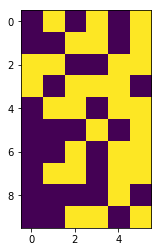

In [35]:
for m in range(1, number_of_iterations+1):
    print("Iteration {:}".format(m))
    
    # Train a model with 4 inputs and 1 dummy output.
    model.fit({'image_1': X1, 'image_2': X2, 'similarity': y, 'weight': W}, [y], verbose=False, epochs=number_of_epochs)
    beta *= beta_factor
    
    # Test output
    # Get sample output
    representation_model = Model(image_a, encoded_a)
    pred_X1 = representation_model.predict(X1)
    plt.imshow(pred_X1[:10])
    plt.show()

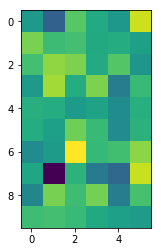

In [33]:
plt.imshow(dense_layer.get_weights()[0][:10])

## Visualize Performance 

__Obtain a representation model__

This representation model is the same as the trained model above without the loss layer at the very end.

In [28]:
representation_model = Model(image_a, encoded_a)

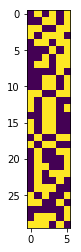

In [38]:
# Get sample output
pred_X1 = representation_model.predict(X1)
plt.imshow(pred_X1[:30] > 0)

# Notes

In [32]:
# Notes:
# https://github.com/keras-team/keras/blob/master/examples/variational_autoencoder.py
#https://github.com/keras-team/keras/issues/7379